In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import YearLocator

In [11]:
# Load the dataset
data = pd.read_csv("historic_demand_2009_2023_noNaN.csv")
#display the dataframe
data

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262045,2023-12-28 21:30:00,44,21:30:00,25436,26868,23487,4694,6488,0,15905,0,24,460,-4,239,278,-28,795,0
262046,2023-12-28 22:00:00,45,22:00:00,24034,25936,22264,4671,6488,0,15905,0,132,293,-4,105,356,37,223,0
262047,2023-12-28 22:30:00,46,22:30:00,23044,25099,21226,4647,6488,0,15905,0,200,142,-4,102,257,-20,195,0
262048,2023-12-28 23:00:00,47,23:00:00,21230,25455,19620,4616,6488,0,15905,0,587,-1537,-4,170,111,-70,228,0


In [12]:
# Convert the 'settlement_date' column to datetime format and set it as the index
data['settlement_date'] = pd.to_datetime(data['settlement_date'])
data.set_index('settlement_date', inplace=True)

# Focus on the 'tsd' column for forecasting and resample to daily frequency
tsd_daily = data['tsd'].resample('D').mean().interpolate()
# Display the first few rows of the TSD series to confirm changes
tsd_daily.head()

settlement_date
2009-01-01    38528.395833
2009-01-02    41133.458333
2009-01-03    40667.791667
2009-01-04    41013.958333
2009-01-05    47322.312500
Freq: D, Name: tsd, dtype: float64

Text(0.5, 1.0, 'Distribution of Transmission System Demand')

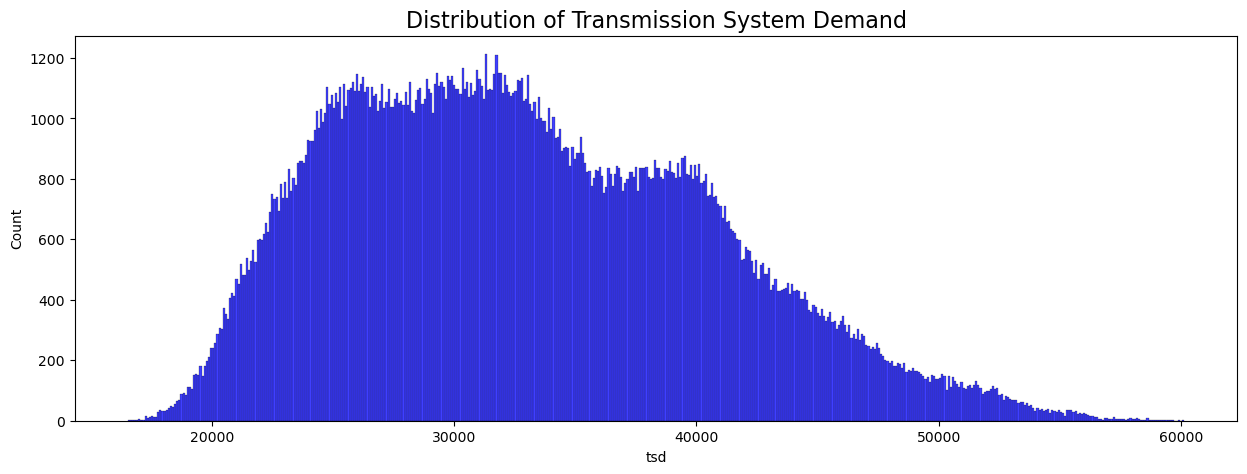

In [13]:
#check for outliers 
fig, ax = plt.subplots(figsize=(15, 5))
# Set the aesthetic style of the plots

sns.histplot(data=data, x="tsd", bins=500, ax=ax, color="b")
# Add title to the plot
plt.title("Distribution of Transmission System Demand", fontsize=16)


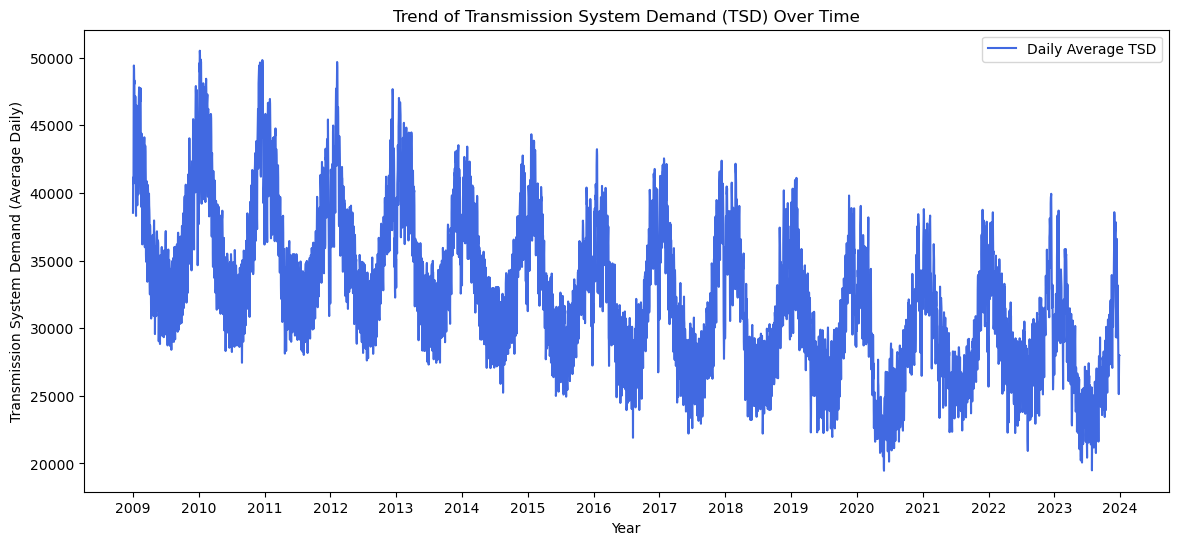

In [14]:
# Plotting the trend of TSD over time
plt.figure(figsize=(14, 6))
plt.plot(tsd_daily, label='Daily Average TSD', color='royalblue')
plt.title('Trend of Transmission System Demand (TSD) Over Time')
plt.xlabel('Year')
plt.ylabel('Transmission System Demand (Average Daily)')
plt.gca().xaxis.set_major_locator(YearLocator())

plt.legend()
plt.show()

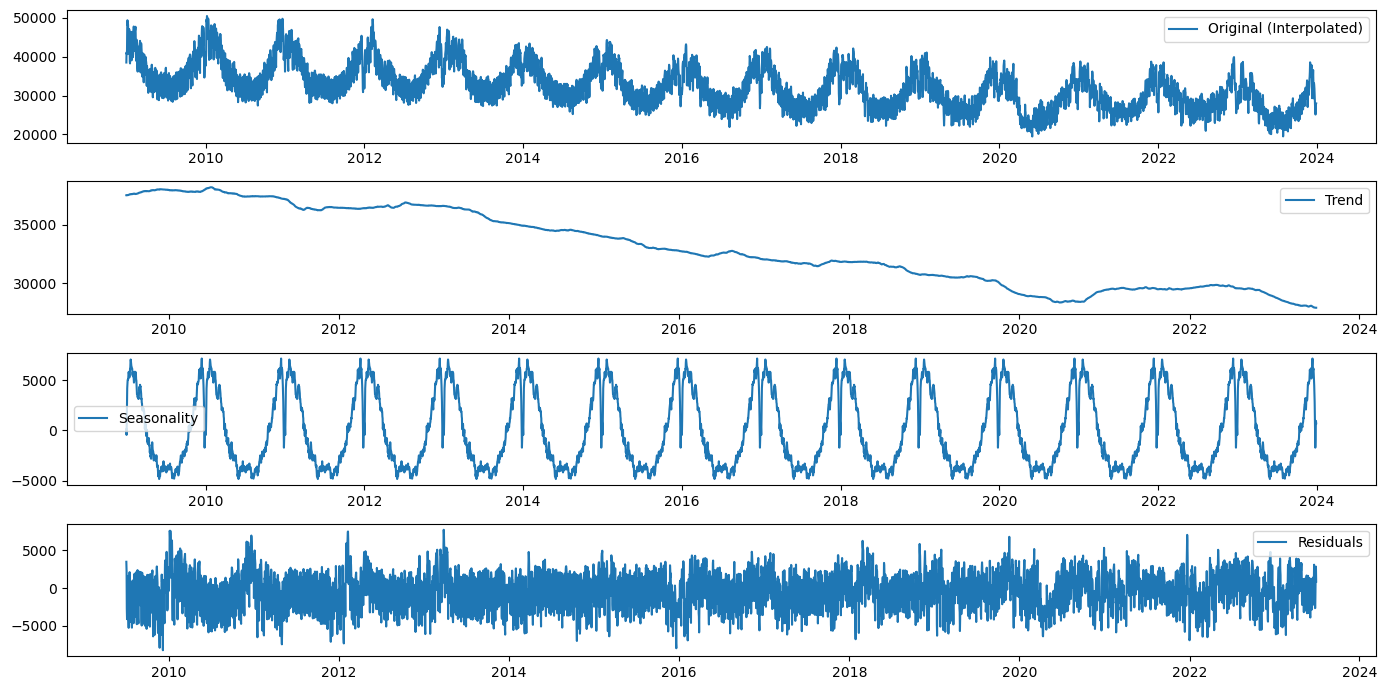

In [6]:
# seasonal decomposition with the interpolated data
decomposition = seasonal_decompose(tsd_daily, model='additive', period=365)


# Plotting the decomposition of the interpolated data
plt.figure(figsize=(14, 7))

plt.subplot(411)
plt.plot(tsd_daily, label='Original (Interpolated)')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.show()



In [7]:
# Extracting year, month, week, and day for aggregation
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Week'] = data.index.isocalendar().week.astype(int) 
data['Date'] = data.index.date

### Aggregate demand data
# Yearly Average Demand
yearly_avg_demand = data.groupby('Year')['tsd'].mean().reset_index()

# Monthly Average Demand
monthly_avg_demand = data.groupby(['Year', 'Month'])['tsd'].mean().reset_index()
monthly_avg_demand['Month_Name'] = monthly_avg_demand['Month'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))

# Weekly Average Demand
weekly_avg_demand = data.groupby(['Year', 'Week'])['tsd'].mean().reset_index()

# Daily Average Demand
daily_avg_demand = data.groupby(['Year', 'Date'])['tsd'].mean().reset_index()
# choose a recent year for daily average
daily_avg_demand_2023 = daily_avg_demand[daily_avg_demand['Year'] == 2023]

# Displaying the first few rows of each aggregation to verify
yearly_avg_demand.head(), monthly_avg_demand.head(), weekly_avg_demand.head(), daily_avg_demand.head()


(   Year           tsd
 0  2009  37522.079497
 1  2010  38227.071626
 2  2011  36488.787476
 3  2012  36611.436384
 4  2013  36288.599612,
    Year  Month           tsd Month_Name
 0  2009      1  44154.180108        Jan
 1  2009      2  43317.789435        Feb
 2  2009      3  39532.255047        Mar
 3  2009      4  35285.631250        Apr
 4  2009      5  33647.017473        May,
    Year  Week           tsd
 0  2009     1  40335.901042
 1  2009     2  46671.627976
 2  2009     3  43725.330357
 3  2009     4  43808.425595
 4  2009     5  44093.633929,
    Year        Date           tsd
 0  2009  2009-01-01  38528.395833
 1  2009  2009-01-02  41133.458333
 2  2009  2009-01-03  40667.791667
 3  2009  2009-01-04  41013.958333
 4  2009  2009-01-05  47322.312500)

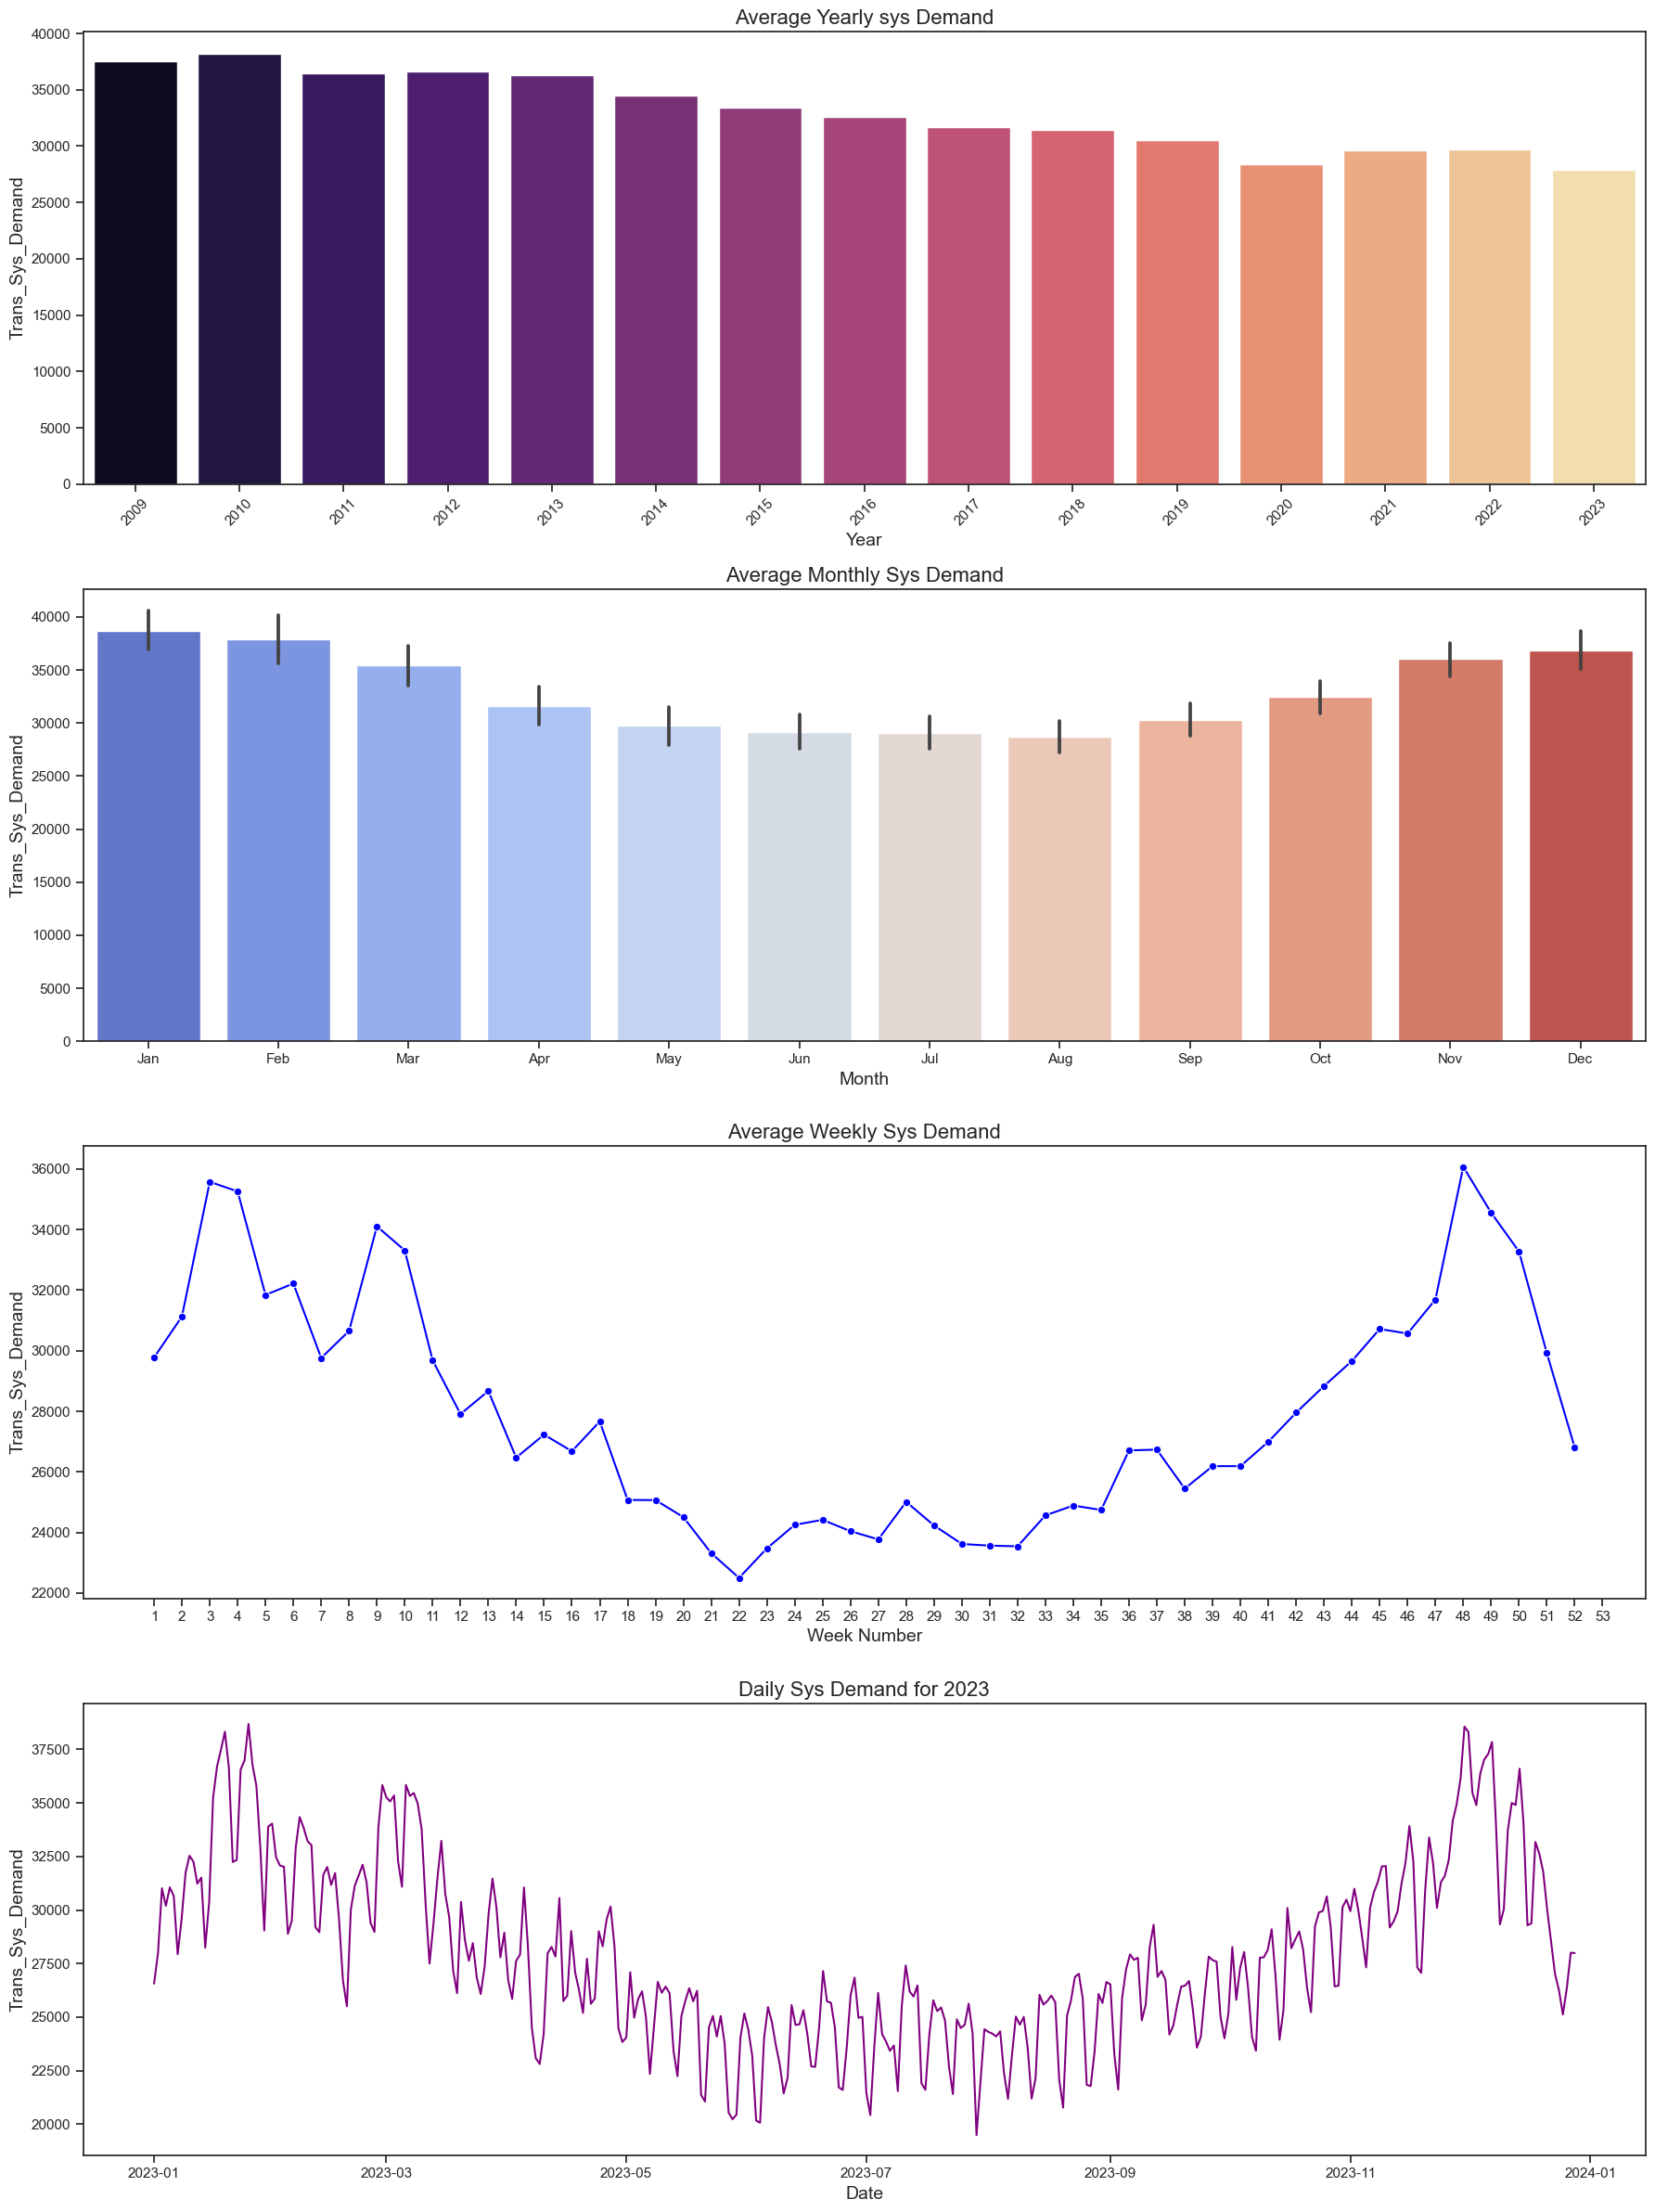

In [8]:
# Setting up the plotting environment
# Adjusting seaborn theme for a light background
sns.set_theme(style="ticks")
fig, ax = plt.subplots(4, 1, figsize=(18, 24)) 
    
# Plotting Yearly Demand Trends
sns.barplot(x='Year', y='tsd', data=yearly_avg_demand, palette='magma', ax=ax[0])
ax[0].set_title('Average Yearly sys Demand', fontsize=16)
ax[0].set_xlabel('Year', fontsize=14)
ax[0].set_ylabel('Trans_Sys_Demand', fontsize=14)
ax[0].tick_params(axis='x', rotation=45)  # Corrected method to rotate x-tick labels

# Plotting Monthly Demand Trends
sns.barplot(x='Month_Name', y='tsd', data=monthly_avg_demand, palette='coolwarm', ax=ax[1])
ax[1].set_title('Average Monthly Sys Demand', fontsize=16)
ax[1].set_xlabel('Month', fontsize=14)
ax[1].set_ylabel('Trans_Sys_Demand', fontsize=14)

# Plotting Weekly Demand Trends
sns.lineplot(x='Week', y='tsd', data=weekly_avg_demand[weekly_avg_demand['Year'] == 2023], marker='o', color='blue', ax=ax[2])
ax[2].set_title('Average Weekly Sys Demand', fontsize=16)
ax[2].set_xlabel('Week Number', fontsize=14)
ax[2].set_ylabel('Trans_Sys_Demand', fontsize=14)
ax[2].set_xticks(range(1, 54))


# Plotting Daily Demand Trends for a specific recent year (e.g., 2023)
sns.lineplot(x=pd.to_datetime(daily_avg_demand_2023['Date']), y='tsd', data=daily_avg_demand_2023, color='purple', ax=ax[3])
ax[3].set_title('Daily Sys Demand for 2023', fontsize=16)
ax[3].set_xlabel('Date', fontsize=14)
ax[3].set_ylabel('Trans_Sys_Demand', fontsize=14)

plt.tight_layout()
plt.show()

In [9]:
#PREPARE THE DATA FOR PROPHET
# Prepare the data for Prophet
prophet_df = tsd_daily.reset_index().rename(columns={'settlement_date': 'ds', 'tsd': 'y'})


# Split data into training and testing set
split_date = prophet_df['ds'].max() - pd.Timedelta(days=365)
train_df = prophet_df[prophet_df['ds'] <= split_date]
test_df = prophet_df[prophet_df['ds'] > split_date]

# Identifying holiday dates from the original dataset
holiday_dates = data[data['is_holiday'] == 1].reset_index()[['settlement_date']].drop_duplicates()
holiday_dates['holiday'] = 'holiday'
# Prepare holidays dataframe
holiday_dates['ds'] = holiday_dates['settlement_date'].dt.date
holiday_dates = holiday_dates[['ds', 'holiday']].drop_duplicates().copy()

# Check the structure of holiday_dates_unique
print(holiday_dates.head())

             ds  holiday
0    2009-01-01  holiday
48   2009-04-10  holiday
96   2009-04-13  holiday
144  2009-05-04  holiday
192  2009-05-25  holiday


In [10]:
# Instantiate and fit the Prophet model with holidays
model = Prophet(holidays=holiday_dates)
model.fit(train_df)

21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:12 - cmdstanpy - INFO - Chain [1] done processing


In [16]:

# Make predictions
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)

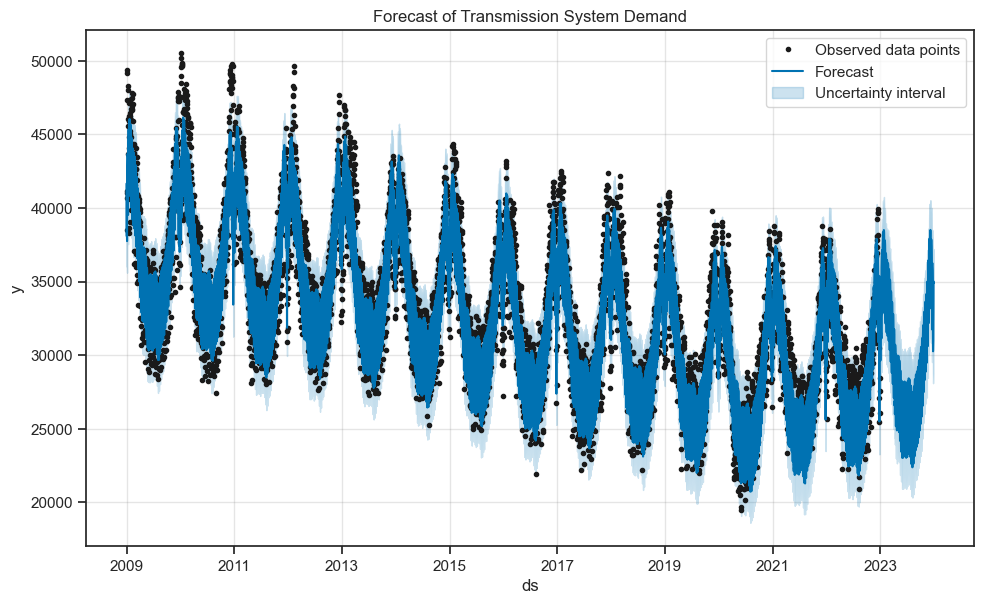

In [17]:
# Plot the forecast
model.plot(forecast)
plt.title('Forecast of Transmission System Demand')
plt.legend()
plt.show()


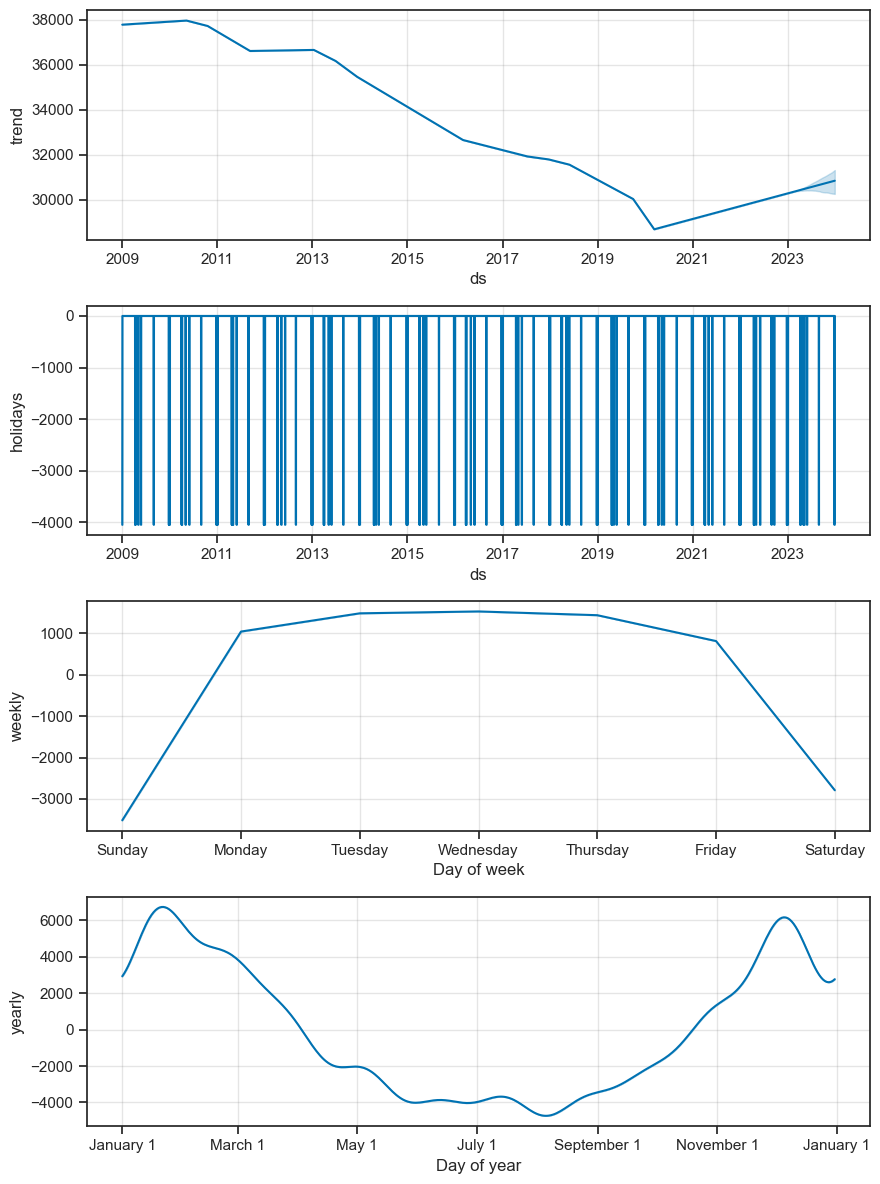

In [18]:
# Plot the components of the forecast
model.plot_components(forecast)
plt.show()

In [19]:
# Extract predicted and actual values
predictions = forecast[-len(test_df):]['yhat']
actuals = test_df['y']

In [20]:
# Calculate accuracy metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))

mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print(f'MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%')

MAE: 2637.0463515849133, RMSE: 2999.4012060490254, MAPE: 9.679248791652945%


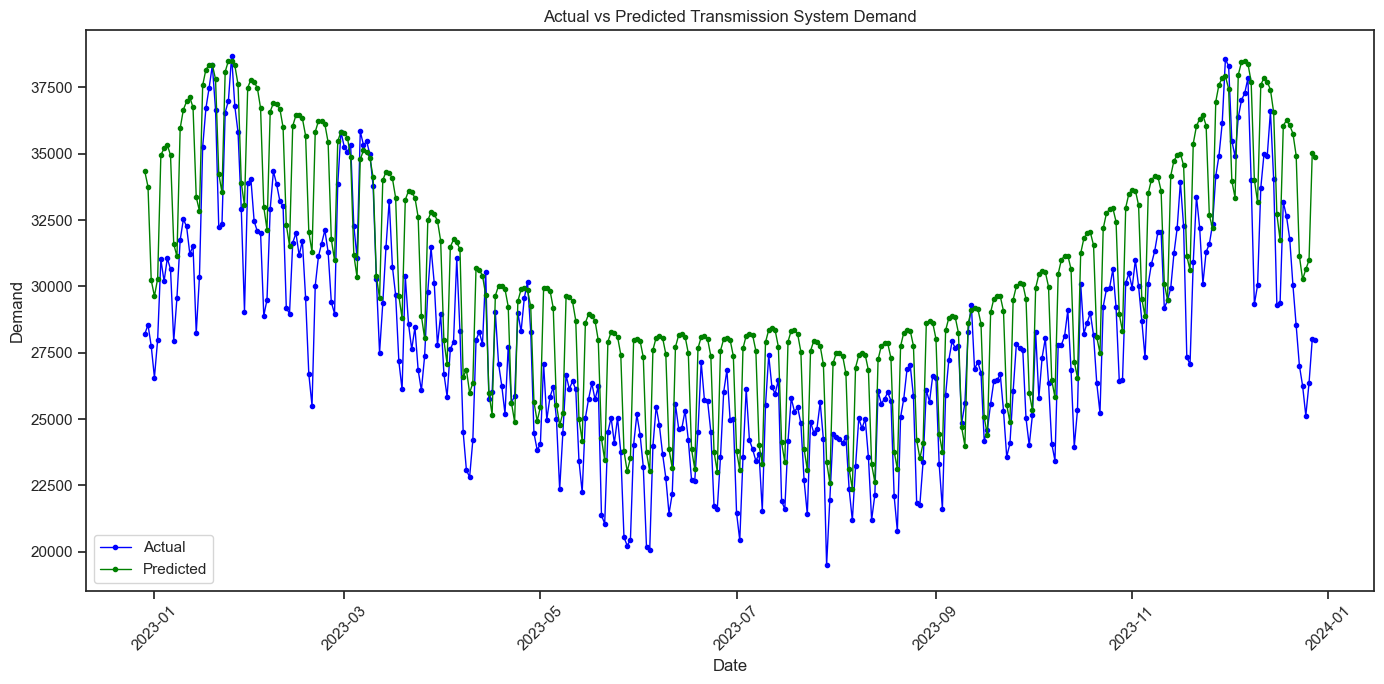

In [21]:
# Visualizing the forecast using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], actuals, label='Actual', color='blue', marker='.', linestyle='-', linewidth=1)
plt.plot(test_df['ds'], predictions, label='Predicted', color='green', marker='.', linestyle='-', linewidth=1)
plt.title('Actual vs Predicted Transmission System Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

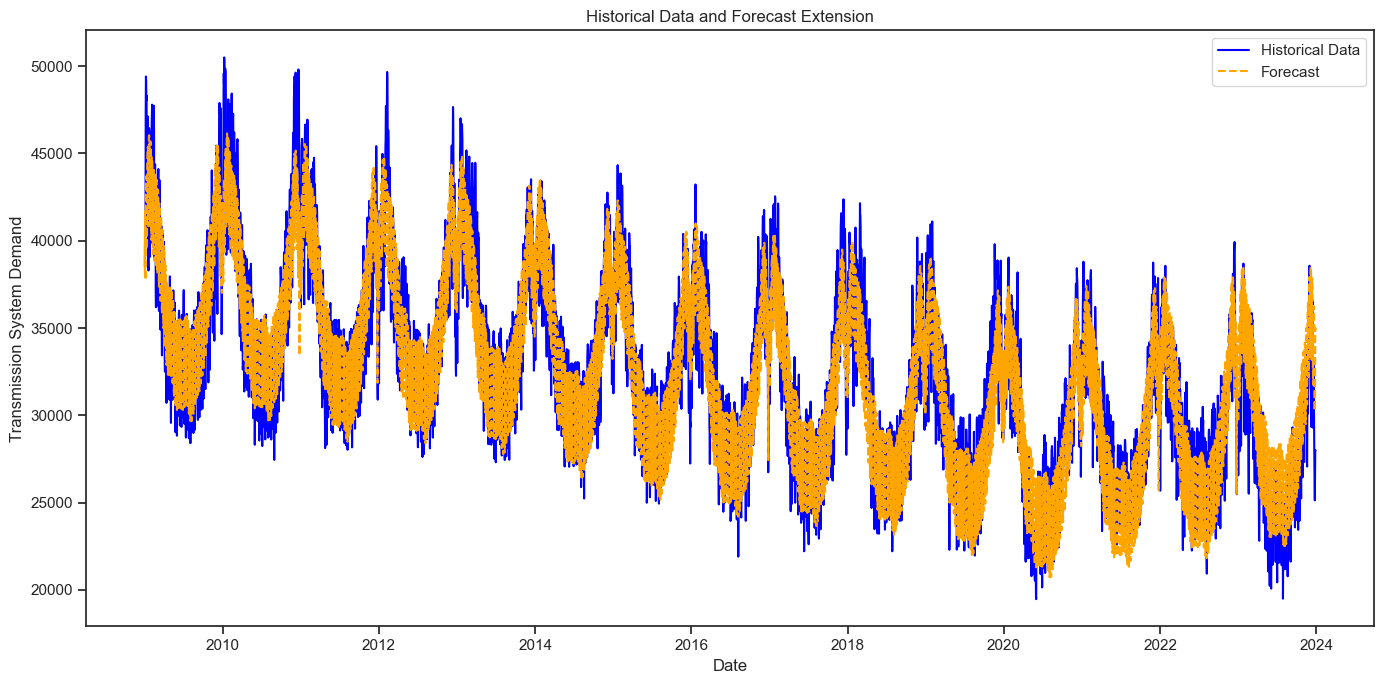

In [22]:
# Plot historical data
plt.figure(figsize=(14, 7))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Historical Data', color='blue')

# Plot forecasted data
# Assuming 'forecast' dataframe includes predictions ('yhat') for both the historical and future period
forecast_dates = forecast['ds']
forecast_values = forecast['yhat']

# Highlight the forecast period
plt.plot(forecast_dates, forecast_values, label='Forecast', color='orange', linestyle='--')

plt.title('Historical Data and Forecast Extension')
plt.xlabel('Date')
plt.ylabel('Transmission System Demand')
plt.legend()
plt.tight_layout()
plt.show()


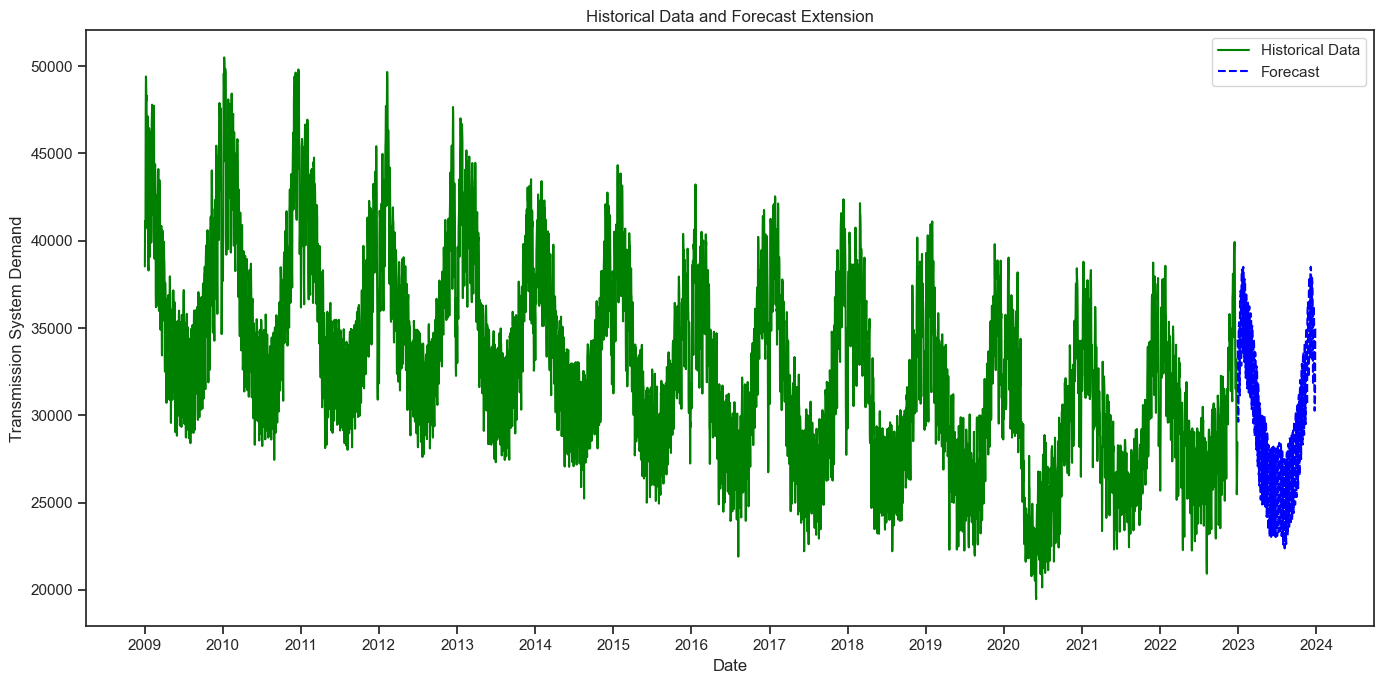

In [23]:
import matplotlib.pyplot as plt

# Historical data up to the split date
historical_data = prophet_df[prophet_df['ds'] <= split_date]

# Forecast data for the test period onwards
forecast_test_period = forecast[forecast['ds'] > split_date]

plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(historical_data['ds'], historical_data['y'], label='Historical Data', color='green')

# Plot forecast data
plt.plot(forecast_test_period['ds'], forecast_test_period['yhat'], label='Forecast', color='blue', linestyle='--')

plt.title('Historical Data and Forecast Extension')
plt.xlabel('Date')
plt.ylabel('Transmission System Demand')
plt.gca().xaxis.set_major_locator(YearLocator())
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
last_historical_date = train_df['ds'].max()
forecast_next_year = forecast[forecast['ds'] > last_historical_date]

# Display the forecast for the next year
forecast_next_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(365)



,ds,yhat,yhat_lower,yhat_upper
5110,2022-12-29,34335.790581,32026.495970,36416.386953
5111,2022-12-30,33760.443978,31780.296796,35866.503662
5112,2022-12-31,30241.284779,28239.595864,32447.231050
5113,2023-01-01,29631.412128,27304.389144,31748.316248
5114,2023-01-02,30292.908565,28218.741038,32422.907657
...,...,...,...,...
5470,2023-12-24,30261.877463,28092.648062,32426.641332
5471,2023-12-25,30646.344914,28477.572490,32812.687098
5472,2023-12-26,30988.478548,28752.333124,33077.842764
5473,2023-12-27,35013.570609,32916.237014,37207.835425


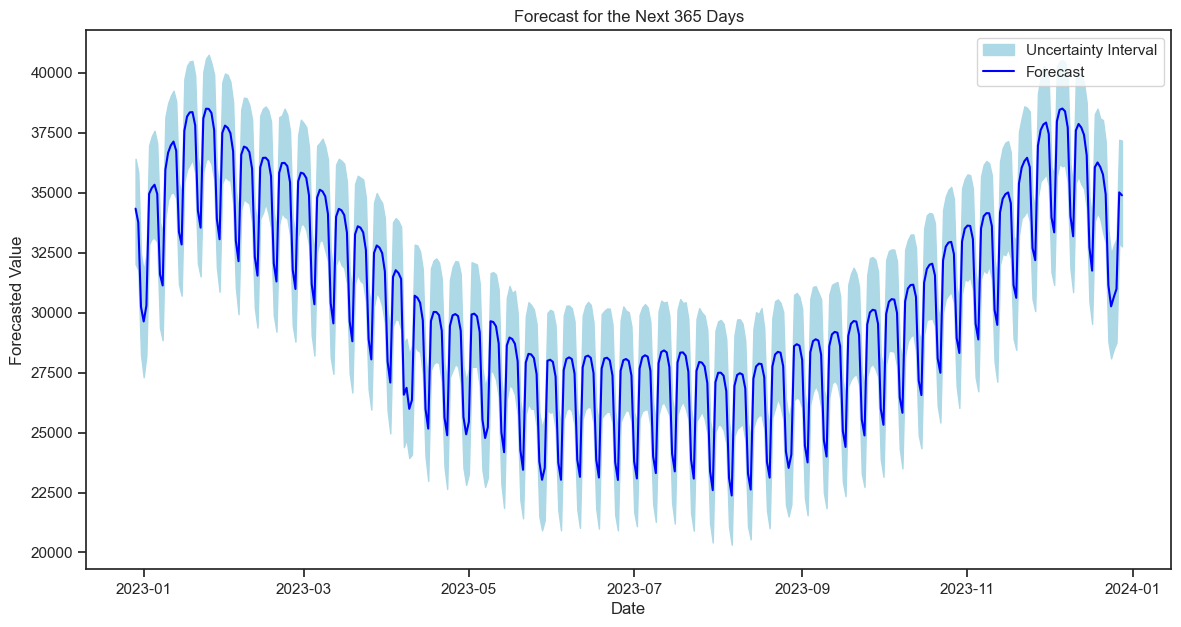

In [25]:
plt.figure(figsize=(14, 7))
plt.fill_between(forecast_next_year['ds'], forecast_next_year['yhat_lower'], forecast_next_year['yhat_upper'], color='lightblue', label='Uncertainty Interval')
plt.plot(forecast_next_year['ds'], forecast_next_year['yhat'], color='blue', label='Forecast')
plt.title('Forecast for the Next 365 Days')
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.legend()
plt.show()

In [15]:
### USING LSTM TO FORECAST DEMAND
#determine the sizes of the train, val and test
total_size = len(tsd_daily)

# Define split proportions
train_ratio = 0.7
validation_ratio = 0.2
# Note: Test ratio is implicitly determined as whatever remains

# Calculate sizes of the splits
train_size = int(total_size * train_ratio)
validation_size = int(total_size * validation_ratio)
test_size = total_size - train_size - validation_size

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# fit the scaler only to the training data to prevent data leakage
tsd_daily_scaled = scaler.fit_transform(tsd_daily[:train_size].values.reshape(-1, 1))

#apply the transformation to the validation and test data using the fitted scaler
tsd_daily_scaled_validation = scaler.transform(tsd_daily[train_size:train_size+validation_size].values.reshape(-1, 1))
tsd_daily_scaled_test = scaler.transform(tsd_daily[train_size+validation_size:].values.reshape(-1, 1))


In [16]:
# Define the look_back period
look_back = 24

# Function to create dataset with look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [17]:
# Prepare the training, validation, and test data
X_train, Y_train = create_dataset(tsd_daily_scaled, look_back)
X_validation, Y_validation = create_dataset(tsd_daily_scaled_validation, look_back)
X_test, Y_test = create_dataset(tsd_daily_scaled_test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

In [44]:
# Defining the LSTM model
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dropout(0.2))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 24, 200)           161600    
                                                                 
 dropout_9 (Dropout)         (None, 24, 200)           0         
                                                                 
 lstm_10 (LSTM)              (None, 150)               210600    
                                                                 
 dropout_10 (Dropout)        (None, 150)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 151       
                                                                 
Total params: 372351 (1.42 MB)
Trainable params: 372351 (1.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_validation, Y_validation))


Epoch 1/100
119/119 - 15s - loss: 0.0157 - val_loss: 0.0073 - 15s/epoch - 126ms/step
Epoch 2/100
119/119 - 8s - loss: 0.0110 - val_loss: 0.0080 - 8s/epoch - 67ms/step
Epoch 3/100
119/119 - 8s - loss: 0.0109 - val_loss: 0.0085 - 8s/epoch - 64ms/step
Epoch 4/100
119/119 - 8s - loss: 0.0107 - val_loss: 0.0074 - 8s/epoch - 64ms/step
Epoch 5/100
119/119 - 6s - loss: 0.0108 - val_loss: 0.0073 - 6s/epoch - 52ms/step
Epoch 6/100
119/119 - 7s - loss: 0.0106 - val_loss: 0.0068 - 7s/epoch - 55ms/step
Epoch 7/100
119/119 - 7s - loss: 0.0088 - val_loss: 0.0053 - 7s/epoch - 62ms/step
Epoch 8/100
119/119 - 7s - loss: 0.0058 - val_loss: 0.0037 - 7s/epoch - 58ms/step
Epoch 9/100
119/119 - 7s - loss: 0.0050 - val_loss: 0.0037 - 7s/epoch - 55ms/step
Epoch 10/100
119/119 - 7s - loss: 0.0045 - val_loss: 0.0035 - 7s/epoch - 59ms/step
Epoch 11/100
119/119 - 8s - loss: 0.0040 - val_loss: 0.0032 - 8s/epoch - 64ms/step
Epoch 12/100
119/119 - 7s - loss: 0.0037 - val_loss: 0.0032 - 7s/epoch - 59ms/step
Epoch 13/1

Epoch 100/100
119/119 - 11s - loss: 0.0018 - val_loss: 0.0020 - 11s/epoch - 96ms/step


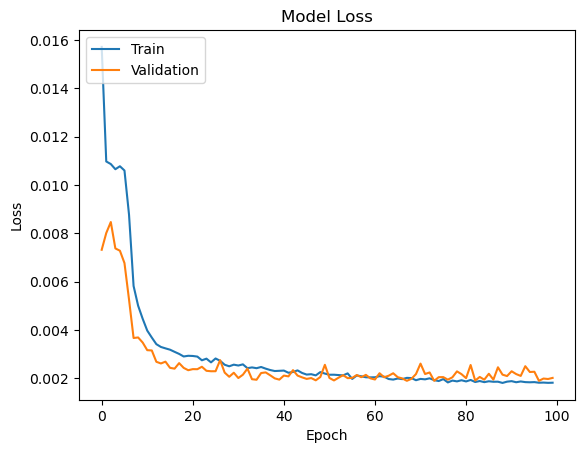

In [47]:
# Plot the loss metrics
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [48]:
### MODEL EVALUATION
# Predict on the test dataset
y_pred = model.predict(X_test)

#reshape the testing data to 2D
y_pred_reshaped = y_pred.reshape(-1, 1)
Y_test_reshaped = Y_test.reshape(-1, 1) 

# Inverse transform to get actual values
test_predict_inv = scaler.inverse_transform(y_pred_reshaped)
Y_test_inv = scaler.inverse_transform(Y_test_reshaped)

# Trim the last elements from Y_test_inv to match the length of test_predict_inv
Y_test_inv = Y_test_inv[:len(test_predict_inv)]

# Calculate metrics
mae = mean_absolute_error(Y_test_inv, test_predict_inv)
mse = mean_squared_error(Y_test_inv, test_predict_inv)
rmse = math.sqrt(mse)
# Calculate MAPE
mape = np.mean(np.abs((Y_test_inv - test_predict_inv) / Y_test_inv)) * 100

# Print the results
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


17/17 [==============================] - 1s 23ms/step
Mean Absolute Percentage Error (MAPE): 3.63%
Mean Absolute Error (MAE): 1001.8436880295363
Root Mean Squared Error (RMSE): 1313.122313985076


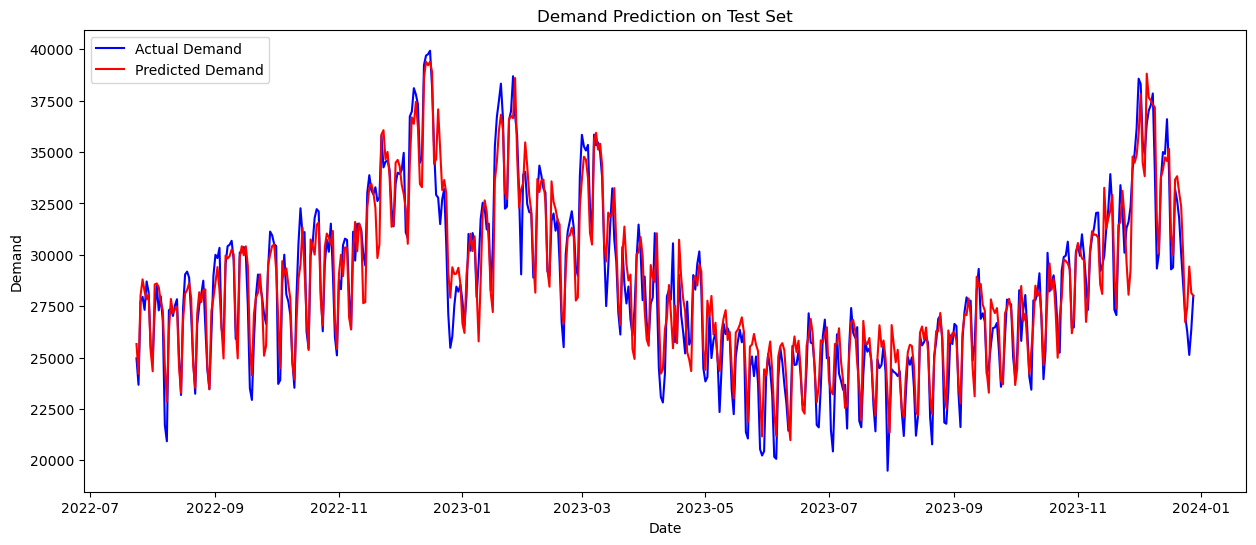

In [49]:
# Visualize the prediction
plt.figure(figsize=(15, 6))
plt.plot(tsd_daily.index[-len(Y_test_inv):], Y_test_inv, label='Actual Demand', color='blue')
plt.plot(tsd_daily.index[-len(test_predict_inv):], test_predict_inv, label='Predicted Demand', color='red')
plt.title('Demand Prediction on Test Set')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 29ms/step


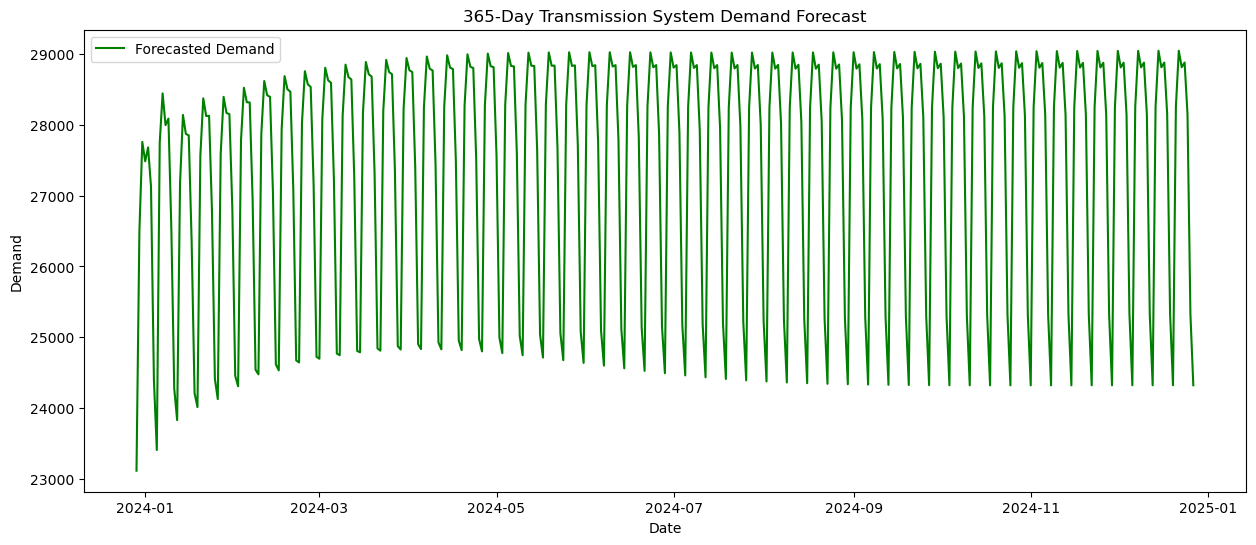

In [50]:
### MAKE FORECASTE FOR THE NEXT 365 DAYS
# Function to generate forecast 
def forecast_next_days(initial_data, model, scaler, days=365, look_back=24):
    forecasted = list(initial_data[-look_back:].flatten()) 
    
    # Forecast day by day
    for _ in range(days):
        # Prepare the input for prediction
        x = np.array(forecasted[-look_back:]).reshape(1, look_back, 1)
        # Predict the next value
        y_hat = model.predict(x)
        
        # Extract scalar value from the prediction and append to forecasted
        forecasted_scalar = y_hat[0, 0]  
        forecasted.append(forecasted_scalar)
    
    # Inverse transform to get actual values
    forecasted_actual = scaler.inverse_transform(np.array(forecasted[-days:]).reshape(-1, 1))
    
    return forecasted_actual

# Forecast the next 365 days
forecasted_values = forecast_next_days(tsd_daily_scaled, model, scaler, days=365, look_back=24)

# Extract the last date in the dataset
last_date = tsd_daily.index[-1]

# Generate a date range for the next 365 days
forecast_dates = pd.date_range(start=last_date, periods=366)[1:] 

# Visualize the 365 days forecast
plt.figure(figsize=(15, 6))
plt.plot(forecast_dates, forecasted_values, label='Forecasted Demand', color='green')
plt.title('365-Day Transmission System Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 26ms/step


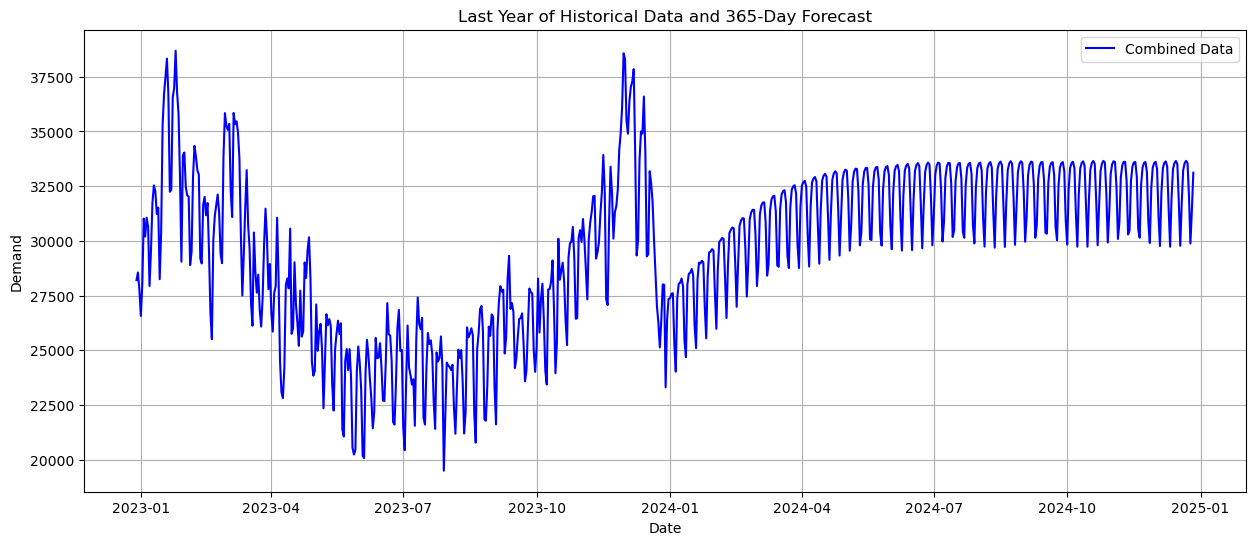

In [43]:
# Function to generate forecast 
def forecast_next_days(initial_data, model, scaler, days=365, look_back=24):
    forecasted = list(initial_data[-look_back:].flatten()) 
    
    # Forecast day by day
    for _ in range(days):
        # Prepare the input for prediction
        x = np.array(forecasted[-look_back:]).reshape(1, look_back, 1)
        # Predict the next value
        y_hat = model.predict(x)
        
        # Extract scalar value from the prediction and append to forecasted
        forecasted_scalar = y_hat[0, 0]  
        forecasted.append(forecasted_scalar)
    
    # Inverse transform to get actual values
    forecasted_actual = scaler.inverse_transform(np.array(forecasted[-days:]).reshape(-1, 1))
    
    return forecasted_actual

# Forecast the next 365 days
forecasted_values = forecast_next_days(tsd_daily_scaled, model, scaler, days=365, look_back=24)

# Extract the last date in the dataset
last_date = tsd_daily.index[-1]

# Generate a date range for the next 365 days
forecast_dates = pd.date_range(start=last_date, periods=366)[1:] 
# Extract the last year of historical data
last_year_data = tsd_daily.iloc[-365:]

# Concatenate the last year of historical data with forecasted values for visualization
combined_dates = np.concatenate((last_year_data.index, forecast_dates))
combined_values = np.concatenate((last_year_data.values.flatten(), forecasted_values.flatten()))

# Visualize the combined last year of historical data and 365-day forecast
plt.figure(figsize=(15, 6))
plt.plot(combined_dates, combined_values, label='Combined Data', color='blue')
plt.title('Last Year of Historical Data and 365-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()